# Exercice Juin 2025 - DHIS2 extraction & DHIS2 extraction pipeline
Premier essai dans VSC
Objectif = 
- Code qui va chercher des certains DataElements  (liste de 10 DataElements) , les extraire, pendant 4 périodes différentes.C
- Ces 10 éléments doivent etre dans des DataSets différents,
- Les périodes ne doivent pas être continue (eg. Janvier, Avril, Juin, Aout)
- Pour certaines OU qui sont dans un Orgunit Groups (ou list manuel).
- Le faire pour un niveau (FOSA) puis en agrégant puis District. Parfois à des niveau différents FOSA et District
- Petite analyse en conclusion
- Utiliser Git et Github !


Writing openHexa pipeline = https://github.com/BLSQ/openhexa/wiki/Writing-OpenHexa-pipelines 

Partie 1 - Connection à DHIS2

In [1]:
USERNAME = "admin"
PASSWORD = "district"
auth = (USERNAME,PASSWORD) 
base_url = "https://play.im.dhis2.org/stable-2-42-0/api/29/"

In [2]:
import pandas as pd
import requests

import os
from openhexa.sdk import workspace
from datetime import datetime

# Récupère le chemin du dossier pipeline
output_dir = workspace.files_path
print(output_dir)

# Vérifie que ce dossier existe vraiment
if not os.path.isdir(output_dir):
    output_dir = "./outputs"
    os.makedirs(output_dir, exist_ok=True)


# Vérifications
print("workspace.files_path:", workspace.files_path)
print("output_dir utilisé:", output_dir)

/home/hexa/workspace
workspace.files_path: /home/hexa/workspace
output_dir utilisé: ./outputs


# Extraction des OU (Pyramide)

# Test de paramètre - message de politesse



In [3]:
url = f"{base_url}organisationUnits"

params = {
    "fields": "id,name,shortName,level,openingDate,closedDate,ancestors[id,name]",
    "paging": "false",
}

response = requests.get(url, params=params, auth=auth)
response.raise_for_status()

data = response.json()
OU = pd.DataFrame(data["organisationUnits"])
print(len(OU))

# Crée des colonnes pour chaque niveau d'ancêtre
max_ancestor_depth = OU['ancestors'].apply(len).max()
print (max_ancestor_depth)

for i in range(max_ancestor_depth):
    OU[f'ancestor_{i}_id'] = OU['ancestors'].apply(lambda x: x[i]['id'] if len(x) > i else None)
    OU[f'ancestor_{i}_name'] = OU['ancestors'].apply(lambda x: x[i]['name'] if len(x) > i else None)

OU.drop(columns=['ancestors','openingDate','closedDate','shortName'], inplace=True)
OU.rename(columns={
    'ancestor_0_name': '1_country',
    'ancestor_1_name': '2_district',
    'ancestor_2_name': '3_chiefdom',
    'ancestor_0_id': '1_country_id',
    'ancestor_1_id': '2_district_id',
    'ancestor_2_id': '3_chiefdom_id'
}, inplace=True)


# Enregistrement en CSV
filename = f"organisation_units_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
output_csv_path = os.path.join(output_dir, filename)
print("output_csv_path:", output_csv_path)
OU.to_csv(output_csv_path, index=False)



# Enregistrement en Parquet
filename = f"organisation_units_{datetime.now().strftime('%Y%m%d_%H%M%S')}.parquet"
output_parquet_path = os.path.join(output_dir, filename)
print("output_parquet_path:", output_parquet_path)
OU.to_parquet(output_parquet_path, index=False)


OU.head()

1332
3
output_csv_path: ./outputs/organisation_units_20250704_094714.csv
output_parquet_path: ./outputs/organisation_units_20250704_094714.parquet


,name,id,level,1_country_id,1_country,2_district_id,2_district,3_chiefdom_id,3_chiefdom
0,Adonkia CHP,Rp268JB6Ne4,4,ImspTQPwCqd,Sierra Leone,at6UHUQatSo,Western Area,qtr8GGlm4gg,Rural Western Area
1,Afro Arab Clinic,cDw53Ej8rju,4,ImspTQPwCqd,Sierra Leone,at6UHUQatSo,Western Area,qtr8GGlm4gg,Rural Western Area
2,Agape CHP,GvFqTavdpGE,4,ImspTQPwCqd,Sierra Leone,O6uvpzGd5pu,Bo,U6Kr7Gtpidn,Kakua
3,Ahamadyya Mission Cl,plnHVbJR6p4,4,ImspTQPwCqd,Sierra Leone,PMa2VCrupOd,Kambia,QywkxFudXrC,Magbema
4,Ahmadiyya Muslim Hospital,BV4IomHvri4,4,ImspTQPwCqd,Sierra Leone,eIQbndfxQMb,Tonkolili,NNE0YMCDZkO,Yoni


In [4]:
# Extraction de la liste de tous les dataElements

import pandas as pd
import requests
url = f"{base_url}dataElements"

params = {
    "paging": "false",
    "fields": "id,name,domainType"
}
 # Corrected variable name from PASSWORD to PASSWORD

response = requests.get(url, params=params, auth=auth)
data = response.json()
DEs = pd.DataFrame(data["dataElements"])
print(f"Nombre de dataElements : {len(DEs)}")
DEs.head(10)

Nombre de dataElements : 1037


,name,domainType,id
0,Accute Flaccid Paralysis (Deaths < 5 yrs),AGGREGATE,FTRrcoaog83
1,Acute Flaccid Paralysis (AFP) follow-up,AGGREGATE,P3jJH5Tu5VC
2,Acute Flaccid Paralysis (AFP) new,AGGREGATE,FQ2o8UBlcrS
3,Acute Flaccid Paralysis (AFP) referrals,AGGREGATE,M62VHgYT2n0
4,Additional medication,TRACKER,WO8yRIZb7nb
5,Additional notes related to facility,AGGREGATE,uF1DLnZNlWe
6,Admission Date,TRACKER,eMyVanycQSC
7,Age in years,TRACKER,qrur9Dvnyt5
8,Age of LLINs,TRACKER,JuTpJ2Ywq5b
9,Albendazole given at ANC (2nd trimester),AGGREGATE,hCVSHjcml9g


In [5]:
try:
    data_element_list
except NameError:
    data_element_list = "DE_list_1"

try:
    user_name
except NameError:
    user_name = "TestUser"
# Choix de 10 DATALEMENTS pour l'exercice


DE_list_1 = ["ANC 1st visit", "ANC 2nd visit"]
DE_list_2 = ["ANC 1st visit", "ANC 2nd visit", "ANC 3rd visit", "ANC 4th or more visits",
                 "Total Population", "Total population < 1 year", "Total population < 5 years", "Population of women of child bearing age (WRA)",
                 "Inpatient malaria cases", "Prevalence of tuberculosis (per 100 000 population)"]

# Sélection de la bonne liste
if data_element_list == "DE_list_1":
    DE_selected = DE_list_1
elif data_element_list == "DE_list_2":
    DE_selected = DE_list_2
else:
    raise ValueError(f"Paramètre data_element_list inconnu : {data_element_list}")




for DE in DE_selected:
    if DE not in DEs["name"].values:
        raise ValueError(f"Data element '{DE}' not found in the list of data elements.")

# Filtrage des dataElements pour ne garder que ceux qui sont dans DE_selecte

DE_selected = DEs[DEs["name"].isin(DE_selected)]

# Vérification que les dataElements sélectionnés sont de type AGGREGATE
for _, DE in DE_selected.iterrows():
    if DE["domainType"] ==  "TRACKER":
        raise ValueError(
            f"Data element '{DE['name']}' is a TRACKER DE.\n Please choose only AGGREGATE data elements.")
print(f"Nombre de dataElements sélectionnés : {len(DE_selected)}")
DE_selected.head(100)

Nombre de dataElements sélectionnés : 2


,name,domainType,id
20,ANC 1st visit,AGGREGATE,fbfJHSPpUQD
21,ANC 2nd visit,AGGREGATE,cYeuwXTCPkU


# Extraction des valeurs des DEs sélectionné

In [6]:
url = f"{base_url}dataValueSets"

params = {
    "dataElement": ",".join(DE_selected["id"].tolist()),
    "period": ["202501", "202504", "202506"],      
    "orgUnitGroup": "oRVt7g429ZO",
}

response = requests.get(url, params=params, auth=auth)
data = response.json()


DEs_values = pd.DataFrame(data["dataValues"])
print(f"Nombre de valeurs de dataElements : {len(DEs_values)}")


nb_unique_DE = DEs_values["dataElement"].nunique()
print(f"Nombre de dataElements uniques : {nb_unique_DE}")

Nombre de valeurs de dataElements : 9449
Nombre de dataElements uniques : 2


In [7]:
DEs_values.head(100)

,dataElement,period,orgUnit,categoryOptionCombo,attributeOptionCombo,value,storedBy,created,lastUpdated,comment,followup
0,fbfJHSPpUQD,202501,PuZOFApTSeo,pq2XI5kz2BY,HllvX50cXC0,13,bo2,2010-03-05T00:00:00.000+0000,2010-03-05T00:00:00.000+0000,,False
1,fbfJHSPpUQD,202506,sLKHXoBIqSs,pq2XI5kz2BY,HllvX50cXC0,4,kono1,2010-07-26T00:00:00.000+0000,2010-07-26T00:00:00.000+0000,,False
2,fbfJHSPpUQD,202501,erqWTArTsyJ,pq2XI5kz2BY,HllvX50cXC0,15,bo2,2010-03-09T00:00:00.000+0000,2010-03-09T00:00:00.000+0000,,False
3,fbfJHSPpUQD,202501,egv5Es0QlQP,PT59n8BQbqM,HllvX50cXC0,1,bo2,2010-03-13T00:00:00.000+0000,2010-03-13T00:00:00.000+0000,,False
4,fbfJHSPpUQD,202501,KvE0PYQzXMM,PT59n8BQbqM,HllvX50cXC0,4,bo2,2010-03-17T00:00:00.000+0000,2010-03-17T00:00:00.000+0000,,False
...,...,...,...,...,...,...,...,...,...,...,...
95,fbfJHSPpUQD,202501,KfUCAQoOIae,pq2XI5kz2BY,HllvX50cXC0,9,bo2,2010-03-13T00:00:00.000+0000,2010-03-13T00:00:00.000+0000,,False
96,fbfJHSPpUQD,202501,Q23tMsKOoO6,pq2XI5kz2BY,HllvX50cXC0,1,bo2,2010-03-07T00:00:00.000+0000,2010-03-07T00:00:00.000+0000,,False
97,fbfJHSPpUQD,202501,Q23tMsKOoO6,PT59n8BQbqM,HllvX50cXC0,2,bo2,2010-03-07T00:00:00.000+0000,2010-03-07T00:00:00.000+0000,,False
98,fbfJHSPpUQD,202501,rx9ubw0UCqj,pq2XI5kz2BY,HllvX50cXC0,5,bo2,2010-03-11T00:00:00.000+0000,2010-03-11T00:00:00.000+0000,,False


In [8]:
# Etape 2 - Ajouter le nom des DataElements

DEs_values = DEs_values.merge(DE_selected, left_on="dataElement", right_on="id", suffixes=("", "_DE"))
print(DEs_values["value"].dtype)
DEs_values["value"] = pd.to_numeric(DEs_values["value"], errors="coerce")
print(DEs_values["value"].dtype)
print(len(DEs_values))
DEs_values.head(10)

DEs_values.head(10)

object
int64
9449


,dataElement,period,orgUnit,categoryOptionCombo,attributeOptionCombo,value,storedBy,created,lastUpdated,comment,followup,name,domainType,id
0,fbfJHSPpUQD,202501,PuZOFApTSeo,pq2XI5kz2BY,HllvX50cXC0,13,bo2,2010-03-05T00:00:00.000+0000,2010-03-05T00:00:00.000+0000,,False,ANC 1st visit,AGGREGATE,fbfJHSPpUQD
1,fbfJHSPpUQD,202506,sLKHXoBIqSs,pq2XI5kz2BY,HllvX50cXC0,4,kono1,2010-07-26T00:00:00.000+0000,2010-07-26T00:00:00.000+0000,,False,ANC 1st visit,AGGREGATE,fbfJHSPpUQD
2,fbfJHSPpUQD,202501,erqWTArTsyJ,pq2XI5kz2BY,HllvX50cXC0,15,bo2,2010-03-09T00:00:00.000+0000,2010-03-09T00:00:00.000+0000,,False,ANC 1st visit,AGGREGATE,fbfJHSPpUQD
3,fbfJHSPpUQD,202501,egv5Es0QlQP,PT59n8BQbqM,HllvX50cXC0,1,bo2,2010-03-13T00:00:00.000+0000,2010-03-13T00:00:00.000+0000,,False,ANC 1st visit,AGGREGATE,fbfJHSPpUQD
4,fbfJHSPpUQD,202501,KvE0PYQzXMM,PT59n8BQbqM,HllvX50cXC0,4,bo2,2010-03-17T00:00:00.000+0000,2010-03-17T00:00:00.000+0000,,False,ANC 1st visit,AGGREGATE,fbfJHSPpUQD
5,fbfJHSPpUQD,202501,ZpE2POxvl9P,PT59n8BQbqM,HllvX50cXC0,8,bo2,2010-03-17T00:00:00.000+0000,2010-03-17T00:00:00.000+0000,,False,ANC 1st visit,AGGREGATE,fbfJHSPpUQD
6,fbfJHSPpUQD,202501,ZpE2POxvl9P,pq2XI5kz2BY,HllvX50cXC0,7,bo2,2010-03-17T00:00:00.000+0000,2010-03-17T00:00:00.000+0000,,False,ANC 1st visit,AGGREGATE,fbfJHSPpUQD
7,fbfJHSPpUQD,202501,mGmu0GJ5neg,pq2XI5kz2BY,HllvX50cXC0,21,bo2,2010-03-13T00:00:00.000+0000,2010-03-13T00:00:00.000+0000,,False,ANC 1st visit,AGGREGATE,fbfJHSPpUQD
8,fbfJHSPpUQD,202501,RhJbg8UD75Q,pq2XI5kz2BY,HllvX50cXC0,8,bo2,2010-03-10T00:00:00.000+0000,2010-03-10T00:00:00.000+0000,,False,ANC 1st visit,AGGREGATE,fbfJHSPpUQD
9,fbfJHSPpUQD,202501,EFTcruJcNmZ,pq2XI5kz2BY,HllvX50cXC0,10,bo2,2010-03-04T00:00:00.000+0000,2010-03-04T00:00:00.000+0000,,False,ANC 1st visit,AGGREGATE,fbfJHSPpUQD


In [9]:
# Etape 3 - Ajouter le nom des organisationUnits

DEs_values = DEs_values.merge(OU, left_on="orgUnit", right_on="id", suffixes=("", "_OU"))
DEs_values.head(5)


,dataElement,period,orgUnit,categoryOptionCombo,attributeOptionCombo,value,storedBy,created,lastUpdated,comment,...,id,name_OU,id_OU,level,1_country_id,1_country,2_district_id,2_district,3_chiefdom_id,3_chiefdom
0,fbfJHSPpUQD,202501,PuZOFApTSeo,pq2XI5kz2BY,HllvX50cXC0,13,bo2,2010-03-05T00:00:00.000+0000,2010-03-05T00:00:00.000+0000,,...,fbfJHSPpUQD,Sahn CHC,PuZOFApTSeo,4,ImspTQPwCqd,Sierra Leone,O6uvpzGd5pu,Bo,I4jWcnFmgEC,Niawa Lenga
1,fbfJHSPpUQD,202506,sLKHXoBIqSs,pq2XI5kz2BY,HllvX50cXC0,4,kono1,2010-07-26T00:00:00.000+0000,2010-07-26T00:00:00.000+0000,,...,fbfJHSPpUQD,Njagbwema Fiama CHC,sLKHXoBIqSs,4,ImspTQPwCqd,Sierra Leone,Vth0fbpFcsO,Kono,CF243RPvNY7,Fiama
2,fbfJHSPpUQD,202501,erqWTArTsyJ,pq2XI5kz2BY,HllvX50cXC0,15,bo2,2010-03-09T00:00:00.000+0000,2010-03-09T00:00:00.000+0000,,...,fbfJHSPpUQD,Telu CHP,erqWTArTsyJ,4,ImspTQPwCqd,Sierra Leone,O6uvpzGd5pu,Bo,daJPPxtIrQn,Jaiama Bongor
3,fbfJHSPpUQD,202501,egv5Es0QlQP,PT59n8BQbqM,HllvX50cXC0,1,bo2,2010-03-13T00:00:00.000+0000,2010-03-13T00:00:00.000+0000,,...,fbfJHSPpUQD,Kigbai MCHP,egv5Es0QlQP,4,ImspTQPwCqd,Sierra Leone,O6uvpzGd5pu,Bo,vWbkYPRmKyS,Baoma
4,fbfJHSPpUQD,202501,KvE0PYQzXMM,PT59n8BQbqM,HllvX50cXC0,4,bo2,2010-03-17T00:00:00.000+0000,2010-03-17T00:00:00.000+0000,,...,fbfJHSPpUQD,Mano Yorgbo MCHP,KvE0PYQzXMM,4,ImspTQPwCqd,Sierra Leone,O6uvpzGd5pu,Bo,zFDYIgyGmXG,Bargbo


In [10]:
# Etape 4 - Agrégation des valeurs par période, nom de dataElement et district
agg_df = (
    DEs_values
    .groupby(["period", "name","2_district"], as_index=False)  # ou ["orgUnit", "id"] si tu préfères
    .agg({"value": "sum"})
)
print ("only DE with values will be displayed")
print (len(agg_df))
agg_df.head(100)

only DE with values will be displayed
78


,period,name,2_district,value
0,202501,ANC 1st visit,Bo,2521
1,202501,ANC 1st visit,Bombali,1455
2,202501,ANC 1st visit,Bonthe,604
3,202501,ANC 1st visit,Kailahun,1219
4,202501,ANC 1st visit,Kambia,1277
...,...,...,...,...
73,202506,ANC 2nd visit,Moyamba,1234
74,202506,ANC 2nd visit,Port Loko,1964
75,202506,ANC 2nd visit,Pujehun,1148
76,202506,ANC 2nd visit,Tonkolili,1546


In [11]:


agg_df = (
    DEs_values
    .groupby(["name"], as_index=False)
    .agg(value_sum=("value", "sum"), count=("value", "count"))
)
agg_df.head(10)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"agg_df_{timestamp}.csv"


output_csv_path = os.path.join(output_dir, filename)
agg_df.to_csv(output_csv_path, index=False)
print("Fichier sauvegardé :", output_csv_path)

Fichier sauvegardé : ./outputs/agg_df_2025-07-04_09-47-15.csv


In [12]:
id_to_look = "WUg3MYWQ7pt"
result = DEs.loc[DEs["id"] == id_to_look]
print (result)

                 name domainType           id
840  Total Population  AGGREGATE  WUg3MYWQ7pt


In [13]:
# Ici, je ne comprend pas pourquoi certaines dataElements n'ont pas de valeurs alors qu'elles en ont dans le DHIS2
# Pour cela, on va extraire les valeurs de dataElements pour une période et un groupe

url = f"{base_url}dataValueSets"

params = {
    "dataElement": ["WUg3MYWQ7pt"],    #WUg3MYWQ7pt = "Total Population"
    "period": ["202406"],      
    "orgUnitGroup": ["oRVt7g429ZO"]    #oRVt7g429ZO =  Public facilities
}


response = requests.get(url, params=params, auth=auth)
data = response.json()


DEs_values = pd.DataFrame(data["dataValues"])
print(f"Nombre de valeurs de dataElements : {len(DEs_values)}")


#nb_unique_DE = DEs_values["dataElement"].nunique()
#print(f"Nombre de dataElements uniques : {nb_unique_DE}")
print(url)

Nombre de valeurs de dataElements : 0
https://play.im.dhis2.org/stable-2-42-0/api/29/dataValueSets


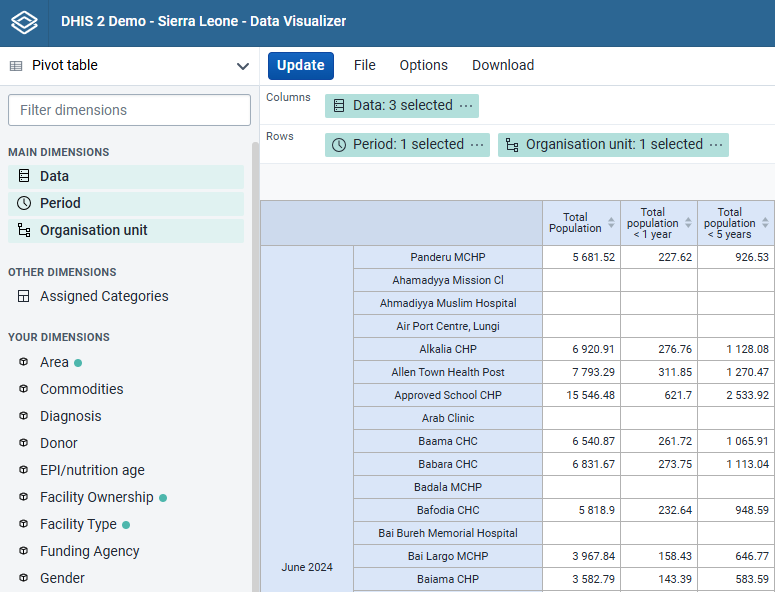